In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 1000)
import math
import warnings
from sklearn import linear_model

from IPython.display import display

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score



In [7]:
# Grab and process the raw data.
#crimestats_baseline = pd.read_csv('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv')
crimestats_baseline = pd.read_csv('Thinkful 2_4 dataframe.csv')
crimestats = crimestats_baseline

In [8]:

crimestats.head(5)


,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0


In [9]:
# renaming the columns to fix the non-standard text in them
crimestats.columns = ['City', 'Population', 'Violent_Crime', 'Murder_and_Nonnegligent_Manslaughter', 'Rape_Revised','Rape_Legacy','Robbery','Aggravated_Assault','Property_Crime','Burglary','Larceny_Theft','Motor_Vehicle_Theft','Arson']

#dropping the first four rows to remove the non-numeric title fluff
crimestats.drop([0,1,2,3], axis=0, inplace=True)

#dropping the last three rows to remove the non-numeric title fluff
crimestats.drop([352,353,354], axis=0, inplace=True)

# dropping the Rape 1 column due to it not having any contents
crimestats.drop('Rape_Revised', axis=1, inplace=True)

# dropping the Arson column due to it having so many NaN values
crimestats.drop('Arson', axis=1, inplace=True)

# Remove 293: Seneca Falls Town due to the massive differential in per-1000-people burglary, property crime, 
# and larceny that it has relative to other cities.
# Remove 220: New York (city) because of just how much of an outlier it is from the rest of the cities.
crimestats.drop(293, axis=0, inplace=True)
crimestats.drop(220, axis=0, inplace=True)

# Removing outliers that showed up in model execution
crimestats.drop(7, axis=0, inplace=True)
crimestats.drop(11, axis=0, inplace=True)
crimestats.drop(39, axis=0, inplace=True)
crimestats.drop(130, axis=0, inplace=True)
crimestats.drop(276, axis=0, inplace=True)
crimestats.drop(314, axis=0, inplace=True)
crimestats.drop(350, axis=0, inplace=True)



In [10]:
# cleaning up the data by removing commas and changing the contents from str to int

def comma_cleaning_and_int(x):
    crimestats[x] = crimestats[x].str.replace(',', '')
    crimestats[x] = crimestats[x].astype(int)

comma_cleaning_and_int('Population')
comma_cleaning_and_int('Violent_Crime')
comma_cleaning_and_int('Murder_and_Nonnegligent_Manslaughter')
comma_cleaning_and_int('Rape_Legacy')
comma_cleaning_and_int('Robbery')
comma_cleaning_and_int('Aggravated_Assault')
comma_cleaning_and_int('Property_Crime')
comma_cleaning_and_int('Burglary')
comma_cleaning_and_int('Larceny_Theft')
comma_cleaning_and_int('Motor_Vehicle_Theft')


In [11]:
# adding in features requested in the drill

def yesno(x):
    if x > 0:
        return 1
    else:
        return 0

crimestats['murder_yesno'] = crimestats.apply(lambda row: yesno(row['Murder_and_Nonnegligent_Manslaughter']), axis=1)

crimestats['robbery_yesno'] = crimestats.apply(lambda row: yesno(row['Robbery']), axis=1)


In [12]:
# creating features using the ratio of crime to population

def popratio(x,y):
    return (1000*(x/y))

crimestats['violent_crime_per1000'] = 1000 * crimestats['Violent_Crime'] / crimestats['Population']

crimestats['murder_per1000'] = 1000 * crimestats['Murder_and_Nonnegligent_Manslaughter'] / crimestats['Population']

crimestats['rape_per1000'] = 1000 * crimestats['Rape_Legacy'] / crimestats['Population']

crimestats['robbery_per1000'] = 1000 * crimestats['Robbery'] / crimestats['Population']

crimestats['assault_per1000'] = 1000 * crimestats['Aggravated_Assault'] / crimestats['Population']

crimestats['propertycrime_per1000'] = 1000 * crimestats['Property_Crime'] / crimestats['Population']

crimestats['burglary_per1000'] = 1000 * crimestats['Burglary'] / crimestats['Population']

crimestats['larceny_per1000'] = 1000 * crimestats['Larceny_Theft'] / crimestats['Population']

crimestats['motorvehicle_crime_per1000'] = 1000 * crimestats['Motor_Vehicle_Theft'] / crimestats['Population']


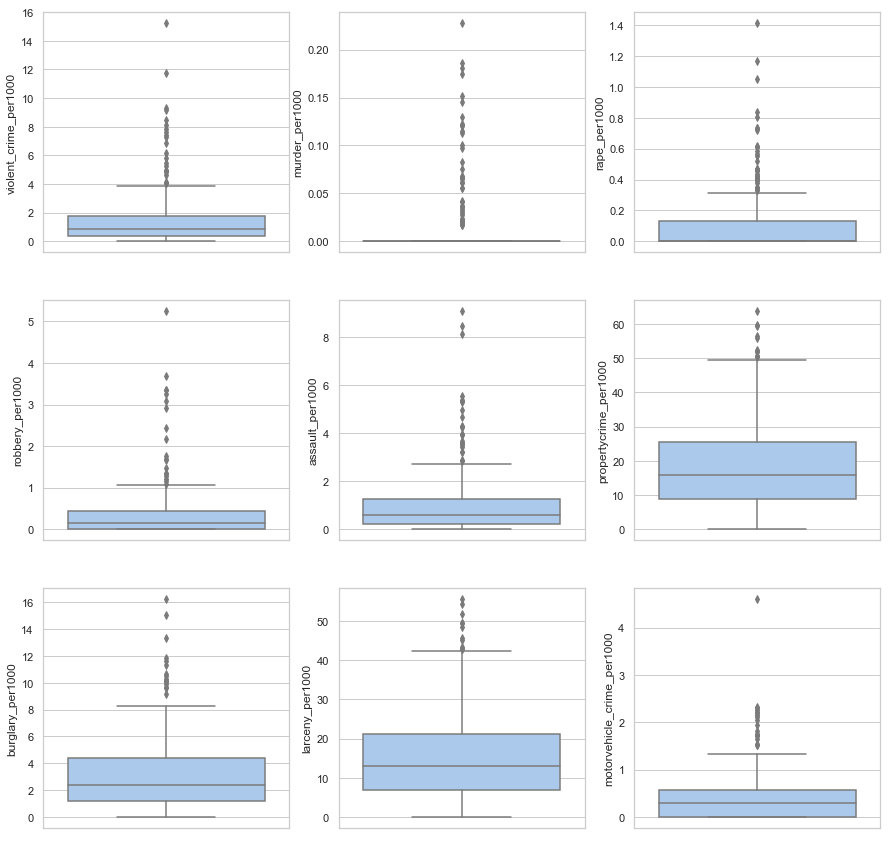

In [13]:
# boxplots to find the outliers in each per-1000 variable

sns.set(style="whitegrid")
plt.figure(figsize=(15, 15))
plt.subplot(3, 3, 1)
sns.boxplot(y = 'violent_crime_per1000', data=crimestats, palette='pastel')  
plt.subplot(3, 3, 2)
sns.boxplot(y = 'murder_per1000', data=crimestats, palette='pastel')  
plt.subplot(3, 3, 3)
sns.boxplot(y = 'rape_per1000', data=crimestats, palette='pastel')  
plt.subplot(3, 3, 4)
sns.boxplot(y = 'robbery_per1000', data=crimestats, palette='pastel')  
plt.subplot(3, 3, 5)
sns.boxplot(y = 'assault_per1000', data=crimestats, palette='pastel')  
plt.subplot(3, 3, 6)
sns.boxplot(y = 'propertycrime_per1000', data=crimestats, palette='pastel')  
plt.subplot(3, 3, 7)
sns.boxplot(y = 'burglary_per1000', data=crimestats, palette='pastel')  
plt.subplot(3, 3, 8)
sns.boxplot(y = 'larceny_per1000', data=crimestats, palette='pastel')  
plt.subplot(3, 3, 9)
sns.boxplot(y = 'motorvehicle_crime_per1000', data=crimestats, palette='pastel')  
plt.show()



In [14]:
# figuring out whether the outliers were specific cities, and whether or not they needed to be removed

print(crimestats.loc[crimestats['violent_crime_per1000'] > 10, ['City', 'violent_crime_per1000']])
print(' ')
print(crimestats.loc[crimestats['murder_per1000'] > .16, ['City', 'murder_per1000']])
print(' ')
print(crimestats.loc[crimestats['rape_per1000'] > 1, ['City', 'rape_per1000']])
print(' ')
print(crimestats.loc[crimestats['robbery_per1000'] > 4, ['City', 'robbery_per1000']])
print(' ')
print(crimestats.loc[crimestats['assault_per1000'] > 6, ['City', 'assault_per1000']])
print(' ')
print(crimestats.loc[crimestats['propertycrime_per1000'] > 60, ['City', 'propertycrime_per1000']])
print(' ')
print(crimestats.loc[crimestats['burglary_per1000'] > 15, ['City', 'burglary_per1000']])
print(' ')
print(crimestats.loc[crimestats['larceny_per1000'] > 55, ['City', 'larceny_per1000']])
print(' ')
print(crimestats.loc[crimestats['motorvehicle_crime_per1000'] > 3, ['City', 'motorvehicle_crime_per1000']])


              City  violent_crime_per1000
213       Newburgh                 15.225
222  Niagara Falls                 11.780
 
                     City  murder_per1000
144     Hempstead Village           0.181
213              Newburgh           0.175
266          Poughkeepsie           0.227
285  Saranac Lake Village           0.186
 
                 City  rape_per1000
145  Herkimer Village         1.170
184     Lyons Village         1.411
300    Sidney Village         1.051
 
         City  robbery_per1000
213  Newburgh            5.250
 
                  City  assault_per1000
213           Newburgh            9.065
222      Niagara Falls            8.129
348  Woodridge Village            8.444
 
                     City  propertycrime_per1000
159  Johnson City Village                 63.837
 
                   City  burglary_per1000
203  Monticello Village            16.256
222       Niagara Falls            15.048
 
                     City  larceny_per1000
159  Johnson City

In [15]:
crimestats['propertycrime_per1000_sqrt'] = crimestats['propertycrime_per1000']**.5
# crimestats['propertycrime_per1000_log'] = np.log(crimestats['propertycrime_per1000'])

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1) 
X_reg1 = pca.fit_transform(crimestats[['propertycrime_per1000_sqrt', 'burglary_per1000', 'larceny_per1000']])
crimestats['property_crime_pca'] = X_reg1

X_reg2 = pca.fit_transform(crimestats[['violent_crime_per1000', 'robbery_per1000']])
crimestats['violent_crime_pca'] = X_reg2

In [17]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crimestats['Property_Crime'].values.reshape(-1, 1)
X = crimestats[['Population','robbery_yesno', 'property_crime_pca', 'violent_crime_pca']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 2.21609631e-02 -1.07935683e+02  1.11526472e+01  4.72607986e+01]]

Intercept: 
 [51.74410197]

R-squared:
0.8350934318479228


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [18]:
predicted = regr.predict(X).ravel()
actual = crimestats['Property_Crime']
residual = actual - predicted

correlation_matrix = X.corr()
display(correlation_matrix)

# Cross Validation, 10 samples
sklearn.model_selection.cross_val_score(regr, X, Y, cv = 10)

,Population,robbery_yesno,property_crime_pca,violent_crime_pca
Population,1.000,0.458,0.134,0.321
robbery_yesno,0.458,1.000,0.438,0.341
property_crime_pca,0.134,0.438,1.000,0.448
violent_crime_pca,0.321,0.341,0.448,1.000


array([0.83890984, 0.88411271, 0.58805301, 0.82338273, 0.84046466,
       0.75846562, 0.80954827, 0.44401856, 0.86211137, 0.85217856])

In [19]:
# F-test and p-values of the features selected
sklearn.feature_selection.f_regression(crimestats[['Population','robbery_yesno', 'property_crime_pca', 'violent_crime_pca']], crimestats['Property_Crime'])

(array([744.60313924,  78.23871489,  79.51586254, 144.04039027]),
 array([2.41817165e-87, 5.21602360e-17, 3.08918712e-17, 7.15734969e-28]))

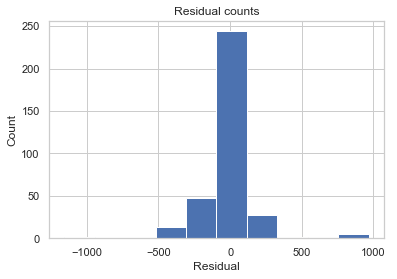

In [20]:
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

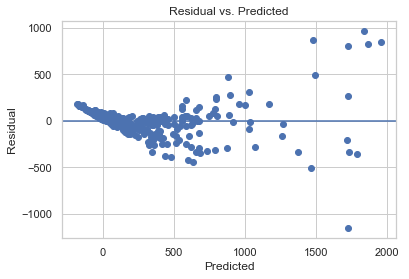

In [21]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()



(271, 4) (271, 1)
(68, 4) (68, 1)
Score: 0.8739842920507183


Text(0, 0.5, 'Predictions')

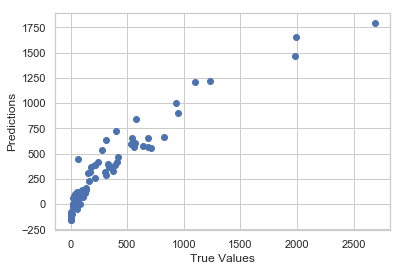

In [22]:
# Holdout, test size 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

model = regr.fit(X_train, y_train)
predictions = regr.predict(X_test)
print('Score: ' + str(model.score(X_test, y_test)))

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')



In [23]:
sklearn.metrics.mean_squared_error(actual, predicted)

31515.739271029626

In [24]:
# A survey of the predicted results to see which are excessive outliers; 
# most were removed in order to improve model performance.

cs_results = crimestats
cs_results['predictions'] = predicted

print(cs_results.loc[cs_results['predictions'] > 3000, ['City', 'Population','Property_Crime','predictions']])


Empty DataFrame
Columns: [City, Population, Property_Crime, predictions]
Index: []


***2014 data model***

In [25]:
crimestats_baseline_2014 = pd.read_csv('Thinkful 2_5 dataframe NY crime 2014.csv')
crimestats14 = crimestats_baseline_2014

In [26]:
crimestats14.head(2)


,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# renaming the columns to fix the non-standard text in them
crimestats14.columns = ['City', 'Population', 'Violent_Crime', 'Murder_and_Nonnegligent_Manslaughter', 'Rape_Revised','Rape_Legacy','Robbery','Aggravated_Assault','Property_Crime','Burglary','Larceny_Theft','Motor_Vehicle_Theft','Arson']

#dropping the first four rows to remove the non-numeric title fluff
crimestats14.drop([0,1,2,3], axis=0, inplace=True)



In [28]:
#dropping the last three rows to remove the non-numeric title fluff
crimestats14.drop([377,376,375,374,373], axis=0, inplace=True)

# dropping the Rape columns due to them having so many NaN values
crimestats14.drop('Rape_Revised', axis=1, inplace=True)
crimestats14.drop('Rape_Legacy', axis=1, inplace=True)

# dropping the Arson column due to it having so many NaN values
crimestats14.drop('Arson', axis=1, inplace=True)


In [29]:
# cleaning up the data by removing commas and changing the contents from str to int
crimestats14.fillna(0, inplace=True)

def comma_cleaning_and_int(x):
    crimestats14[x] = crimestats14[x].astype(str)
    crimestats14[x] = crimestats14[x].str.replace(',', '')
    crimestats14[x] = crimestats14[x].astype(int)

comma_cleaning_and_int('Population')
comma_cleaning_and_int('Violent_Crime')
comma_cleaning_and_int('Murder_and_Nonnegligent_Manslaughter')
comma_cleaning_and_int('Robbery')
comma_cleaning_and_int('Aggravated_Assault')
comma_cleaning_and_int('Property_Crime')
comma_cleaning_and_int('Burglary')
comma_cleaning_and_int('Larceny_Theft')
comma_cleaning_and_int('Motor_Vehicle_Theft')


In [30]:
# adding in features requested in the drill

def yesno(x):
    if x > 0:
        return 1
    else:
        return 0

crimestats14['murder_yesno'] = crimestats14.apply(lambda row: yesno(row['Murder_and_Nonnegligent_Manslaughter']), axis=1)

crimestats14['robbery_yesno'] = crimestats14.apply(lambda row: yesno(row['Robbery']), axis=1)


In [31]:
# creating features using the ratio of crime to population

def popratio(x,y):
    return (1000*(x/y))

crimestats14['violent_crime_per1000'] = 1000 * crimestats14['Violent_Crime'] / crimestats14['Population']

crimestats14['murder_per1000'] = 1000 * crimestats14['Murder_and_Nonnegligent_Manslaughter'] / crimestats14['Population']

crimestats14['robbery_per1000'] = 1000 * crimestats14['Robbery'] / crimestats14['Population']

crimestats14['assault_per1000'] = 1000 * crimestats14['Aggravated_Assault'] / crimestats14['Population']

crimestats14['propertycrime_per1000'] = 1000 * crimestats14['Property_Crime'] / crimestats14['Population']

crimestats14['burglary_per1000'] = 1000 * crimestats14['Burglary'] / crimestats14['Population']

crimestats14['larceny_per1000'] = 1000 * crimestats14['Larceny_Theft'] / crimestats14['Population']

crimestats14['motorvehicle_crime_per1000'] = 1000 * crimestats14['Motor_Vehicle_Theft'] / crimestats14['Population']


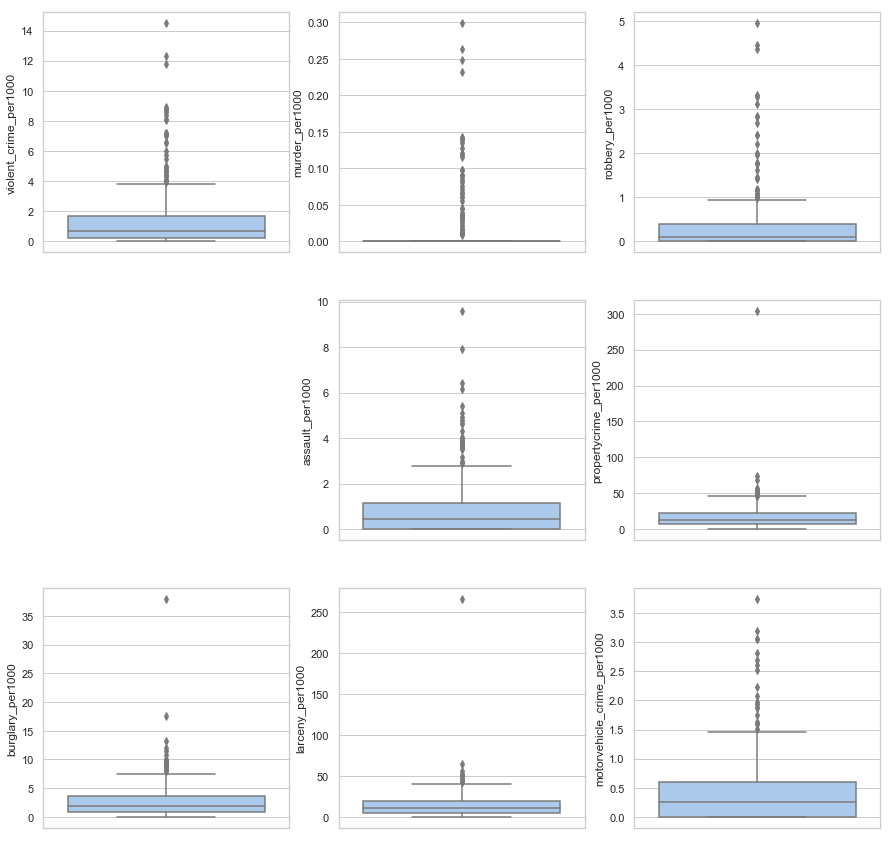

In [32]:
# boxplots to find the outliers in each per-1000 variable

sns.set(style="whitegrid")
plt.figure(figsize=(15, 15))
plt.subplot(3, 3, 1)
sns.boxplot(y = 'violent_crime_per1000', data=crimestats14, palette='pastel')  
plt.subplot(3, 3, 2)
sns.boxplot(y = 'murder_per1000', data=crimestats14, palette='pastel')  
plt.subplot(3, 3, 3)
sns.boxplot(y = 'robbery_per1000', data=crimestats14, palette='pastel')  
plt.subplot(3, 3, 5)
sns.boxplot(y = 'assault_per1000', data=crimestats14, palette='pastel')  
plt.subplot(3, 3, 6)
sns.boxplot(y = 'propertycrime_per1000', data=crimestats14, palette='pastel')  
plt.subplot(3, 3, 7)
sns.boxplot(y = 'burglary_per1000', data=crimestats14, palette='pastel')  
plt.subplot(3, 3, 8)
sns.boxplot(y = 'larceny_per1000', data=crimestats14, palette='pastel')  
plt.subplot(3, 3, 9)
sns.boxplot(y = 'motorvehicle_crime_per1000', data=crimestats14, palette='pastel')  
plt.show()



In [33]:
# figuring out whether the outliers were specific cities, and whether or not they needed to be removed

print(crimestats14.loc[crimestats14['violent_crime_per1000'] > 10, ['City', 'violent_crime_per1000']])
print(' ')
print(crimestats14.loc[crimestats14['murder_per1000'] > .16, ['City', 'murder_per1000']])
print(' ')
print(crimestats14.loc[crimestats14['robbery_per1000'] > 4, ['City', 'robbery_per1000']])
print(' ')
print(crimestats14.loc[crimestats14['assault_per1000'] > 6, ['City', 'assault_per1000']])
print(' ')
print(crimestats14.loc[crimestats14['propertycrime_per1000'] > 60, ['City', 'propertycrime_per1000']])
print(' ')
print(crimestats14.loc[crimestats14['burglary_per1000'] > 15, ['City', 'burglary_per1000']])
print(' ')
print(crimestats14.loc[crimestats14['larceny_per1000'] > 55, ['City', 'larceny_per1000']])
print(' ')
print(crimestats14.loc[crimestats14['motorvehicle_crime_per1000'] > 3, ['City', 'motorvehicle_crime_per1000']])


               City  violent_crime_per1000
42         Buffalo4                 12.282
225       Newburgh4                 14.483
233  Niagara Falls4                 11.785
 
                        City  murder_per1000
11           Alfred Village4           0.248
42                  Buffalo4           0.232
56   Cayuga Heights Village4           0.264
215      Monticello Village4           0.299
 
                  City  robbery_per1000
42            Buffalo4            4.942
151  Hempstead Village            4.451
225          Newburgh4            4.370
 
                 City  assault_per1000
42           Buffalo4            6.435
152  Herkimer Village            6.147
225         Newburgh4            9.585
233    Niagara Falls4            7.931
 
                      City  propertycrime_per1000
96   East Syracuse Village                 67.987
169  Johnson City Village4                 73.529
245   Ocean Beach Village4                303.797
 
                     City  burglary_pe

In [34]:
# Remove outliers in boxplot data
crimestats14.drop(11, axis=0, inplace=True)
crimestats14.drop(42, axis=0, inplace=True)
crimestats14.drop(56, axis=0, inplace=True)
crimestats14.drop(225, axis=0, inplace=True)
crimestats14.drop(233, axis=0, inplace=True)
crimestats14.drop(215, axis=0, inplace=True)
crimestats14.drop(151, axis=0, inplace=True)
crimestats14.drop(245, axis=0, inplace=True)

# Remove 231: New York (city) because of just how much of an outlier it is from the rest of the cities.
crimestats14.drop(231, axis=0, inplace=True)

# Remove outliers in model run
crimestats14.drop(287, axis=0, inplace=True)
crimestats14.drop(330, axis=0, inplace=True)
crimestats14.drop(370, axis=0, inplace=True)



In [35]:
crimestats14['propertycrime_per1000_sqrt'] = crimestats14['propertycrime_per1000']**.5
# crimestats['propertycrime_per1000_log'] = np.log(crimestats['propertycrime_per1000'])

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3) 
X_reg1 = pca.fit_transform(crimestats14[['propertycrime_per1000_sqrt', 'burglary_per1000', 'larceny_per1000']])
crimestats14['property_crime_pca'] = X_reg1

pca = PCA(n_components=2) 
X_reg2 = pca.fit_transform(crimestats14[['violent_crime_per1000', 'robbery_per1000']])
crimestats14['violent_crime_pca'] = X_reg2

ValueError: Wrong number of items passed 3, placement implies 1

In [ ]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = crimestats14['Property_Crime'].values.reshape(-1, 1)
X = crimestats14[['Population','robbery_yesno', 'property_crime_pca', 'violent_crime_pca']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

In [ ]:
# test the model, trained on 2014 data, on the 2013 dataset
X = crimestats[['Population','robbery_yesno', 'property_crime_pca', 'violent_crime_pca']]
Y = crimestats['Property_Crime'].values.reshape(-1, 1)
regr.score(X, Y)

In [ ]:
predicted = regr.predict(X).ravel()
actual = Y
residual = actual - predicted

correlation_matrix = X.corr()
display(correlation_matrix)

# Cross Validation, 10 samples
sklearn.model_selection.cross_val_score(regr, X, Y, cv = 10)

In [ ]:
# F-test and p-values of the features selected
sklearn.feature_selection.f_regression(crimestats14[['Population','robbery_yesno', 'property_crime_pca', 'violent_crime_pca']], crimestats14['Property_Crime'])

In [ ]:
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [ ]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()



In [ ]:
# Holdout, test size 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

model = regr.fit(X_train, y_train)
predictions = regr.predict(X_test)
print('Score: ' + str(model.score(X_test, y_test)))

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')



In [ ]:
sklearn.metrics.mean_squared_error(actual, predicted)

In [ ]:
# A survey of the predicted results to see which are excessive outliers; 
# most were removed in order to improve model performance.

cs_results = crimestats14
cs_results['predictions'] = predicted

print(cs_results.loc[cs_results['predictions'] > 3000, ['City', 'Population','Property_Crime','predictions']])


Used PCA to merge correlated /1000 features together, into two independent features, both of which have noticeable impact on R^2 and significant p-values according to the F-test, using both data sets.  Results of the model are decent in both, though may still be a bit over-fitted based on the 10-sample cross-validation, which still shows a couple of samples in both datasets with around -.3 compared to the mean of the rest.  

Results of a model trained on 2013 data to estimate the property crime rates based on 2014 data were nearly the same as the model trained on the 2014 dataset, so it seems to work reasonably well on other datasets that have been prepared similarly.